In [1]:
import dynamiqs as dq
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
na, nb = 20, 5  # Hilbert space dimensions
g2 = 1.0  # Two-photon coupling strength
eps_d = -4  # Drive amplitude
alpha = jnp.sqrt(-1.0*eps_d/g2)
kappa_b = 10  # Decay rate

# 1.3

For the Z gate, we choose the Hamiltonian to be 
$$H_z = \epsilon_z(a + a^{\dagger})$$ 
and the Loss operator corresponding to single photon loss from the mode a as 
$$\sqrt{\kappa_a} \hat{a}$$
The function zeno below takes $\epsilon_z$ and $\kappa_a$ as input and returns the density matrix of mode a as a function of time $\rho_a(t)$. 

Below, we plot the wigner plot for a z gate with $\kappa_a = 0$ and plot the parity vs. time. We find that the system oscillates between even and odd cat states, but it also leaks information to the environment while it does so. We find that the rate at which it leaks information decreases with increasing time period. The time period of oscillation is inversely proportional to the strength of the $z$ gate $\epsilon_z$

We can also define the time it takes the time evolution that maps $\ket{+}$ to $\ket{-}$ or vice versa:
$$T_z = \frac{\pi}{4 \alpha \epsilon_z}$$

In [3]:
def zeno(eps_z, kappa_a):
    psi0 = dq.tensor(dq.unit(dq.coherent(na, alpha) + dq.coherent(na, -alpha)), dq.fock(nb,0))  # Initial state
    T_z = jnp.pi/(4*alpha*eps_z)
    T = 5*T_z
    
    a, b = dq.destroy(na, nb)
    dag_a, dag_b = dq.dag(a), dq.dag(b)
    H_2ph = g2 * dag_a @ dag_a @ b + jnp.conj(g2) * a @ a @ dag_b
    H_d = jnp.conj(eps_d) * b + eps_d * dag_b
    H_z = eps_z*(dag_a + a)
    H = H_2ph + H_d + H_z
    exp_ops = [dq.dag(a) @ a, dq.dag(b) @ b]
    loss_op = [jnp.sqrt(kappa_b) * b, jnp.sqrt(kappa_a)*a]
    
    t_save = jnp.linspace(0, T, 100)
    res = dq.mesolve(H, loss_op, psi0, t_save, exp_ops=exp_ops)
    rho_a = dq.ptrace(res.states, 0)
    return rho_a, t_save

|███████▎  |  73.3% ◆ elapsed 461.33ms ◆ remaining 172.55ms
|██████████| 100.0% ◆ elapsed 785.20ms ◆ remaining 0.00ms  

100%|██████████| 50/50 [00:05<00:00,  9.42it/s]


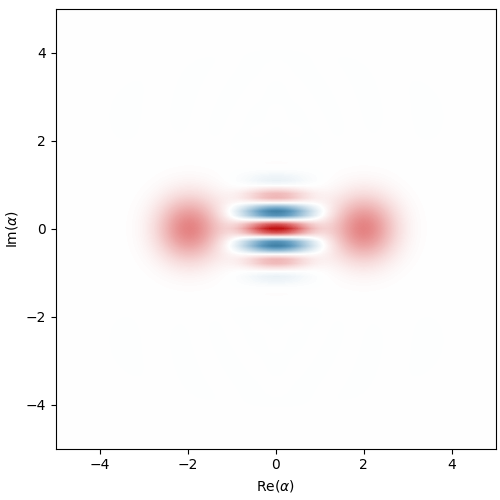

In [4]:
rho , t = zeno(1, 0)
dq.plot.wigner_gif(rho)

Text(0.5, 0, 'Normalized Time')

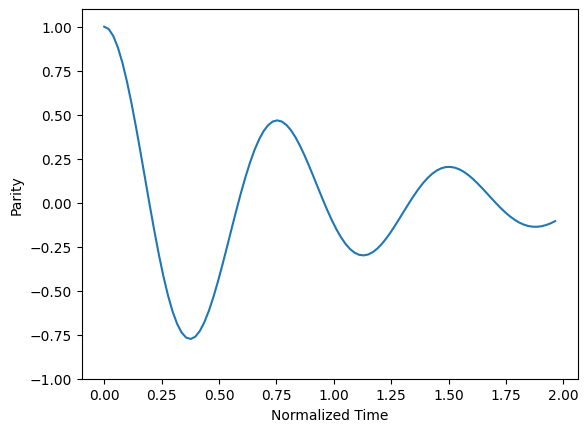

In [6]:
plt.plot(t, dq.expect(dq.parity(na), rho).real)
plt.ylim(-1, 1+0.1)
plt.ylabel("Parity")
plt.xlabel("Normalized Time")

|██████████| 100.0% ◆ elapsed 367.82ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 196.89ms ◆ remaining 0.00ms 
|██████████| 100.0% ◆ elapsed 149.25ms ◆ remaining 0.00ms 


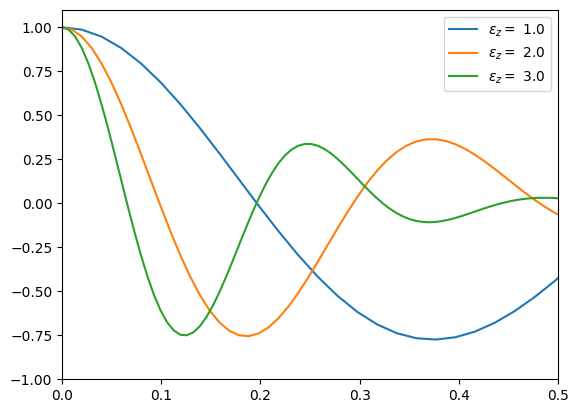

In [47]:
for ez in jnp.linspace(1, 3, 3): 
    rho , t = zeno(ez, 0) 
    plt.plot(t, dq.expect(dq.parity(na), rho).real, label = f'$\epsilon_z =$ {ez}', )
plt.ylim(-1, 1+0.1)
plt.xlim(0, 0.5)
plt.legend() 

|██████████| 100.0% ◆ elapsed 424.07ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 490.11ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 465.65ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 502.28ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 515.58ms ◆ remaining 0.00ms  


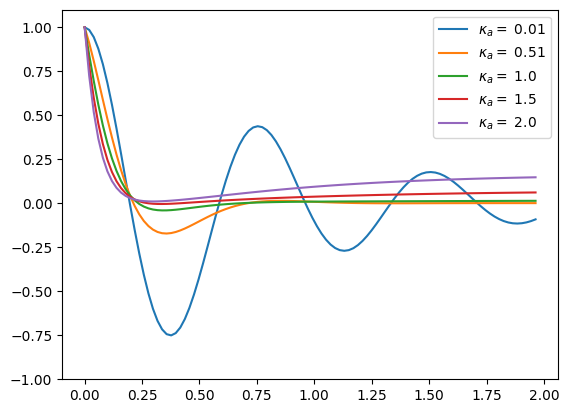

In [7]:
for k in jnp.linspace(0.01, 2, 5):  
    rho , t = zeno(1, k) 
    plt.plot(t, dq.expect(dq.parity(na), rho).real, label = f'$\kappa_a =$ {k:.2}', )
plt.ylim(-1, 1+0.1)
plt.legend() 

Next we find the the optimal values for $\kappa_a$ and $T_z$ for $\kappa_a \in [0.01,2]$ and $\epsilon_z$ for $\theta = 0 \rightarrow \pi$.

In [10]:
a, b = dq.destroy(na, nb)
dag_a, dag_b = dq.dag(a), dq.dag(b)
H_2ph = g2 * dag_a @ dag_a @ b + jnp.conj(g2) * a @ a @ dag_b
H_d = jnp.conj(eps_d) * b + eps_d * dag_b

eps_z = jnp.linspace(0.125,jnp.pi,10)
T_z = jnp.pi/(4*alpha*eps_z)
kappa_a = jnp.linspace(0.01,2,10)
exp = []
    
for e in eps_z:
    exp_per_eps = []
    for k in kappa_a:
        rho_a, t = zeno(e,k)
        z = dq.expect(dq.parity(na), rho_a).real.tolist()[-1]
        exp_per_eps.append(z)
    exp.append(exp_per_eps)

save_j = []
save_i = []
min_row = 0
for i in range(len(exp)):
    save_j.append(min(exp[1]))
    save_i.append(exp[i].index(min(exp[i])))

i = save_j.index(min(save_j))
j = save_i[i]
    
print(exp[i][j])

T_z_optimal = jnp.pi/(4*alpha*eps_z[i])
print("Optimal T_z : " + str(T_z_optimal))
print("Optimal Kappa_a : " + str(kappa_a[j]))

|██████████| 100.0% ◆ elapsed 3.18s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 3.31s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 3.59s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 3.64s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 3.69s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 3.75s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 4.04s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 4.11s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 4.08s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 4.11s ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 874.21ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 845.24ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 994.40ms ◆ remaining 0.00ms  
|██████████| 100.0% ◆ elapsed 1.02s ◆ remaining 0.00ms     
|██████████| 100.0% ◆ elapsed 1.01s ◆ remaining 0.00ms     
|██████████| 100.0% ◆ elapsed 1.07s ◆ remaining 0.00ms     
|██████████| 100.0% ◆ elapsed 1.08s ◆ remaining 0.00ms     
|█████████

-0.20324501395225525
Optimal T_z : 3.1415927
Optimal Kappa_a : 0.01
